In [1]:
import pandas
import xarray
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
# read from netcdf file
xa = xarray.open_dataarray('rain_at_data_points.nc')

xy = np.array([xa['eastings'], xa['northings']]).T

xa

<xarray.DataArray 'rain_at_data_points' (time: 1728, points: 3168)>
[5474304 values with dtype=float64]
Coordinates:
  * time       (time) int64 1580860800000000000 ... 1581378900000000000
    eastings   (points) float64 3.415e+05 3.42e+05 ... 3.578e+05 3.583e+05
    northings  (points) float64 6.342e+06 6.342e+06 ... 6.303e+06 6.303e+06
Dimensions without coordinates: points

In [3]:
#xa['time'] = pandas.to_datetime(xa['time'], utc=True)
xa

<xarray.DataArray 'rain_at_data_points' (time: 1728, points: 3168)>
[5474304 values with dtype=float64]
Coordinates:
  * time       (time) int64 1580860800000000000 ... 1581378900000000000
    eastings   (points) float64 3.415e+05 3.42e+05 ... 3.578e+05 3.583e+05
    northings  (points) float64 6.342e+06 6.342e+06 ... 6.303e+06 6.303e+06
Dimensions without coordinates: points

In [4]:
# Get the extent of the data in the rainfall file
x_min = xy[:,0].min()
x_max = xy[:,0].max()
y_min = xy[:,1].min()
y_max = xy[:,1].max()
x_len = x_max-x_min
y_len = y_max-y_min


x_min, x_max, y_max, y_min, x_len, y_len

(332553.546848531,
 369130.071516474,
 6342125.12653866,
 6303219.2776204,
 36576.52466794301,
 38905.848918260075)

In [5]:
xa['time']

<xarray.DataArray 'time' (time: 1728)>
array([1580860800000000000, 1580861100000000000, 1580861400000000000, ...,
       1581378300000000000, 1581378600000000000, 1581378900000000000])
Coordinates:
  * time     (time) int64 1580860800000000000 ... 1581378900000000000

In [7]:
import anuga
from zoneinfo import ZoneInfo

domain = anuga.rectangular_cross_domain(50,50,len1=x_len, len2=y_len, origin=(x_min,y_min))

# lambda function working with absolute location
domain.set_quantity('elevation', lambda x,y : -(x-x_min)/x_len/10.0)
domain.set_quantity('stage', lambda x,y : -(x-x_min)/x_len/10.0)

rain_op = anuga.Rate_operator(domain, rate=xa, factor=1, verbose=True) #factor=1.0/1000/300)  # mm/5min m/1000mm 5min/300s

# Pull start time from rainfall data
# FIXME SR: Clean up this conversion 
starttimestamp = (xa['time'][0].values.astype('int64')/1.0e9)
from datetime import datetime, timezone

# For a bit of fun, lets start one hour before the data in the rain file
starttimestamp = starttimestamp + 300

print(starttimestamp)

starttime = datetime.fromtimestamp(starttimestamp, tz=timezone.utc)

print(starttimestamp)
print(starttime)

#domain.set_starttime(starttimestamp)
domain.set_starttime(starttime)

ts = xa.sel(time=starttime, method='ffill')

print(ts)

rain_op()

1023 (3168, 2)
1580861100.0
1580861100.0
2020-02-05 00:05:00+00:00
<xarray.DataArray 'rain_at_data_points' (points: 3168)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    time       datetime64[ns] 2020-02-05T00:05:00
    eastings   (points) float64 3.415e+05 3.42e+05 ... 3.578e+05 3.583e+05
    northings  (points) float64 6.342e+06 6.342e+06 ... 6.303e+06 6.303e+06
Dimensions without coordinates: points
1580861100.0 2020-02-05 00:05:00+00:00
UTC time 2020-02-05 00:05:00+00:00 type <class 'pandas._libs.tslibs.timestamps.Timestamp'> 
<xarray.DataArray 'rain_at_data_points' (points: 3168)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    time       datetime64[ns] 2020-02-05T00:05:00
    eastings   (points) float64 3.415e+05 3.42e+05 ... 3.578e+05 3.583e+05
    northings  (points) float64 6.342e+06 6.342e+06 ... 6.303e+06 6.303e+06
Dimensions without coordinates: points
UTC time 2020-02-05 00:05:00+00:00 Q_ref time 2020-02-05T00:05:00.000000000 False 


In [11]:
import anuga
from zoneinfo import ZoneInfo

domain = anuga.rectangular_cross_domain(50,50,len1=x_len, len2=y_len, origin=(x_min,y_min))

# lambda function working with absolute location
domain.set_quantity('elevation', lambda x,y : -(x-x_min)/x_len/10.0)
domain.set_quantity('stage', lambda x,y : -(x-x_min)/x_len/10.0)

Br = anuga.Reflective_boundary(domain)

domain.set_boundary({'left':Br, 'right':Br, 'top':Br, 'bottom':Br})

# Use xarray xa to set rate for Rate_operator
rain_op = anuga.Rate_operator(domain, rate=xa, factor=1.0/1000/300)  # mm/5min m/1000mm 5min/300s


#dplotter = anuga.Domain_plotter(domain)
#plt.triplot(dplotter.triang, linewidth = 0.4);


#domain.set_timezone('Australia/Sydney')


# Pull start time from rainfall data
# FIXME SR: Clean up this conversion 
starttimestamp = (xa['time'][0].values.astype('int64')/1.0e9)
from datetime import datetime, timezone

# For a bit of fun, lets start one hour before the data in the rain file
starttimestamp = starttimestamp

print(starttimestamp)

starttime = datetime.fromtimestamp(starttimestamp, tz=timezone.utc)

print(starttimestamp)
print(starttime)

domain.set_starttime(starttimestamp)

for t in domain.evolve(yieldstep=3600, duration=40*3600): #3600.0*40):
    domain.print_timestepping_statistics(datetime=True)

    print(f'    boundary integral {domain.get_boundary_flux_integral():15.8e} m^3')
    print(f'    operator integral {domain.get_fractional_step_volume_integral():15.8e} m^3')
    print(f'    water volume      {domain.get_water_volume():15.8e} m^3')
    


1580860800.0
1580860800.0
2020-02-05 00:00:00+00:00
2020-02-05 00:00:00.000000+0000: steps=0 (0s)
    boundary integral  0.00000000e+00 m^3
    operator integral  0.00000000e+00 m^3
    water volume       0.00000000e+00 m^3
2020-02-05 01:00:00.000000+0000: delta t = 300.00000000 (s), steps=12 (0s)
    boundary integral  1.54851636e-14 m^3
    operator integral  8.56243560e+05 m^3
    water volume       8.56243560e+05 m^3
2020-02-05 02:00:00.000000+0000: delta t = 300.00000000 (s), steps=12 (0s)
    boundary integral -1.34779019e-14 m^3
    operator integral  8.57502951e+05 m^3
    water volume       8.57502951e+05 m^3
2020-02-05 03:00:00.000000+0000: delta t in [241.61868948, 300.00000000] (s), steps=14 (0s)
    boundary integral -3.59053094e-14 m^3
    operator integral  8.57848826e+05 m^3
    water volume       8.57848826e+05 m^3
2020-02-05 04:00:00.000000+0000: delta t in [199.60300015, 240.26413860] (s), steps=17 (0s)
    boundary integral -2.35252849e-14 m^3
    operator integral 

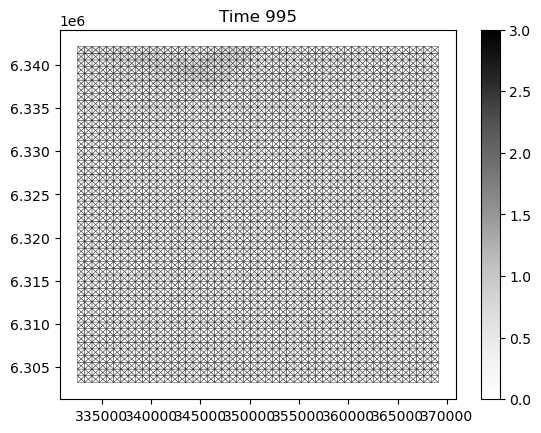

In [12]:
# lets have a look at the rainfall data

# Setup interpolation of rain data to anuga mesh
from scipy.spatial import KDTree

tree = KDTree(xy)

dd, ii = tree.query(domain.centroid_coordinates)

rain_at_centroids = xa[:,ii]

dplotter = anuga.Domain_plotter(domain)

import pylab as pl
import time
from IPython import display
for i in range(200):
    ids = 5*i
    pl.clf()
    pl.tripcolor(dplotter.triang,
                 facecolors = rain_at_centroids[ids,:],
                 vmin = 0.0,
                 vmax = 3.0,
                 edgecolors='k',
                 cmap='Greys')
    pl.colorbar();
    #pl.plot(pl.randn(100), 'o')
    pl.title(f'Time {ids}')
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.25)